In [ ]:
import sys
!{sys.executable} -m pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [ ]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')
%cd drive/MyDrive/twitter_training/

Mounted at /content/drive
/content/drive/MyDrive/twitter_training


In [ ]:
df = pd.read_csv('./p_n_n_tilde_lv.csv')
df = df[['id', 'message_lv_tilde', 'label']]
df.head()

,id,message_lv_tilde,label
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,negative
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,negative
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",negative
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,negative
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,negative


In [ ]:
df['label'].value_counts()

neutral     77028
positive    51994
negative    45622
Name: label, dtype: int64

In [ ]:
newLine ="\\n|\\r"
df['clean_message'] = df['message_lv_tilde'].str.replace(newLine,' ',regex=True).str.strip()
df.head()

,id,message_lv_tilde,label,clean_message
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,negative,@pilsonenjeff @lauferlaw @donwinslows pa reize...
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,negative,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",negative,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk..."
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,negative,Maksvels droši vien pačurās mājā pirms mūsu nā...
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,negative,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...


# Train, validate split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message_lv_tilde  clean_message
label    data_type                                        
negative train      38778             38778          38778
         val         6844              6844           6844
neutral  train      65474             65474          65474
         val        11554             11554          11554
positive train      44195             44195          44195
         val         7799              7799           7799

In [ ]:
df.head()

,id,message_lv_tilde,label,clean_message,data_type
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,negative,@pilsonenjeff @lauferlaw @donwinslows pa reize...,train
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,negative,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,train
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",negative,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",train
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,negative,Maksvels droši vien pačurās mājā pirms mūsu nā...,train
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,negative,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,train


In [ ]:
# df.to_csv('./tweets_base.csv', index=False)

# df = pd.read_csv('./../labeledTweets/p_n_n_and_labeled_corpus_train_val.csv')

## Balance training data

In [ ]:
label_dict = {'neutral': 0, 'positive': 1, 'negative': 2}
df['label'] = df.label.replace(label_dict) 
df['label'].value_counts()

df[df.data_type=='train'].head()

,id,message_lv_tilde,label,clean_message,data_type
0,1.340000e+18,@pilsonenjeff @lauferlaw @donwinslows pa reize...,2,@pilsonenjeff @lauferlaw @donwinslows pa reize...,train
1,1.330000e+18,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,2,@tkdylan cilvēkiem ir aģentūra. Lins Vuds ir v...,train
2,1.330000e+18,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",2,"@foenixaew Es nojaušu, ka WWE lika viņam iznāk...",train
3,1.320000e+18,Maksvels droši vien pačurās mājā pirms mūsu nā...,2,Maksvels droši vien pačurās mājā pirms mūsu nā...,train
4,1.320000e+18,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,2,@msamson56 Esmu pārsteigts. KĀ cilvēki var atb...,train


In [ ]:
df[df.data_type=='train']['label'].value_counts()

0    65474
1    44195
2    38778
Name: label, dtype: int64

In [ ]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_2.shape[0], random_state=42)
df_1_downsampled = df_1.sample(df_2.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_1_downsampled, df_2])

df_train['label'].value_counts()

0    38778
1    38778
2    38778
Name: label, dtype: int64

In [ ]:
df_train.head()

,clean_message,label
166338,Vēlos vēlreiz uz skatuves sveikt savu inaugurā...,0
132679,Dārsijs un Džimijs Vū! #VandaVision!! Tā kļūst...,0
139880,Mūsu politiķus pārbauda un negodīgi izturas pr...,0
165467,"@OAJIGE Es esmu šeit, bet tā es joprojām skato...",0
114196,Mēs pieņemam darbā! par mūsu jaunāko darba atk...,0


In [ ]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
173588,"Šī ir īpašniece. maza, balta sieviete. Viņai p...",0
13813,"Zvēri, ka komanda var stāvēt tukšā rindā ar vi...",2
86357,Vienmēr iedvesmojoši stāsti no kolēģiem @Teach...,1
77889,@ahleee_ Avena ir tā izgaismota. Bet es cienu ...,1
14709,"mamma baidās no tā, kas varētu notikt ar to, k...",2


# Tokenizer "bert-base-multilingual-cased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

### Find max length for tokenizer

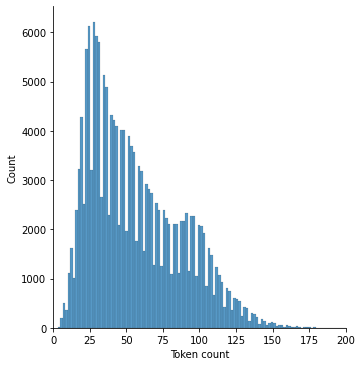

In [ ]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [ ]:
max_length = 190

### Encode messages

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
len(dataset_train), len(dataset_val)

(116334, 26197)

In [ ]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [ ]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [ ]:
# len(dataset_train), len(dataset_val)

# Model "bert-base-multilingual-cased"

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [ ]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)
print(device)

cuda


In [ ]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Evaluate untrained model

In [ ]:
# _, predictions, true_vals = evaluate(dataloader_validation)

# from sklearn.metrics import classification_report, confusion_matrix

# preds_flat = np.argmax(predictions, axis=1).flatten()

# print(classification_report(true_vals, preds_flat))
# pd.DataFrame(confusion_matrix(true_vals, preds_flat),
#         index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
#         columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

# Train

In [ ]:
# torch.cuda.device_count()

In [ ]:
# torch.cuda.memory_allocated(0)

In [ ]:
# torch.cuda.memory_reserved(0)

In [ ]:
# torch.cuda.empty_cache()
# total_memory = torch.cuda.get_device_properties(0).total_memory
# torch.cuda.set_per_process_memory_fraction(0.5, 0)
# application = int(total_memory * 0.499) - torch.cuda.max_memory_reserved()
# tmp_tensor = torch.empty(application, dtype=torch.int8, device='cuda')
# del tmp_tensor
# torch.cuda.empty_cache()

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsBase/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3636 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6137089178834942
Validation loss: 0.4805125680562195
F1 Score (Weighted): 0.8195930613324558
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     11554
           1       0.73      0.86      0.79      7799
           2       0.82      0.89      0.85      6844

    accuracy                           0.82     26197
   macro avg       0.82      0.83      0.82     26197
weighted avg       0.83      0.82      0.82     26197

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral       8693     2107      754
       positive       523     6669      607
       negative       352      400     6092


Epoch 2:   0%|          | 0/3636 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Evaluate

In [ ]:
model.load_state_dict(torch.load('modelsBase/finetuned_BERT_epoch_X.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
preds_flat = np.argmax(predictions, axis=1).flatten()

print(classification_report(true_vals, preds_flat))
print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))